In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [182]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((64,64))
])

In [184]:
dataset_train = ImageFolder(
    "clouds/clouds_train",
    transform = train_transforms
)

In [186]:
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=16
)

In [148]:
image, lable = next(iter(dataloader_train))
image = image.squeeze().permute(1,2,0)

In [150]:
print(image.shape)

torch.Size([128, 128, 3])


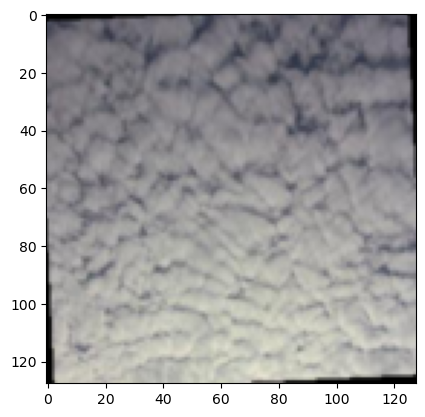

In [ ]:
plt.imshow(image)
plt.show()

## Model class

The model will consist of two parts:

- A feature extractor that learns a vector of features from the input image,
- A classifier that predicts the image's class based on the learned features.

In [180]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
        
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x
    

## Traning loop

In [188]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 1.9176
Epoch 2, Loss: 1.6501
Epoch 3, Loss: 1.3961


## Evaluation

In [190]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64))
])

dataset_test = ImageFolder(
    "clouds/clouds_test",
    transform = test_transforms
)

dataloader_test = DataLoader(
    dataset_test,
    shuffle=True,
    batch_size=16
)

In [192]:
from torchmetrics import Precision, Recall
# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="micro")
metric_recall = Recall(task="multiclass", num_classes=7, average="micro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.5390946269035339
Recall: 0.5390946269035339


In [194]:
# Define metrics
metric_precision = Precision(task="multiclass", num_classes=7, average="macro")
metric_recall = Recall(task="multiclass", num_classes=7, average="macro")

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.48177260160446167
Recall: 0.5306323766708374


In [196]:
# Define precision metric
metric_precision = Precision(task="multiclass", num_classes=7, average=None)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
print(precision_per_class)

{'cirriform clouds': 0.5151515007019043, 'clear sky': 0.8529411554336548, 'cumulonimbus clouds': 0.5333333611488342, 'cumulus clouds': 0.6146789193153381, 'high cumuliform clouds': 0.4375, 'stratiform clouds': 0.0, 'stratocumulus clouds': 0.4188034236431122}
